In [101]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from itertools import combinations
import seaborn as sns
import sys
sys.path.insert(0, r"C:\Users\achil\GIN Dropbox\Achille Gillig\tools\neuroginius")
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

In [102]:
data_dir = Path(r"C:\Users\achil\GIN Dropbox\Achille Gillig\shared\Jonathan_Achille_Shared\memento_data")
n_perm = 100
mat_file = data_dir / f"{n_perm}perm_mean_tangent_patterns.joblib"
perm_mat_file = data_dir / f"{n_perm}perm_mean_tangent_perm_patterns.joblib"

with open(mat_file, 'rb') as f:
    haufe_matrices = joblib.load(f)

with open(perm_mat_file, 'rb') as f:
    perm_haufe_matrices = joblib.load(f)
    

In [103]:
conn_measure = joblib.load(r"C:\Users\achil\GIN Dropbox\Achille Gillig\Projects\memento\article-figures\connectivity_measure.joblib")

diff_matrices = {}
ambient_diff_matrices = {}
null_diff_matrices = {}
#step 1: creation of class differences matrices
classes = ['stable', 'decline']

# tangent_haufe_matrices = haufe_matrices.copy()
ambient_haufe_matrices = conn_measure.inverse_transform(haufe_matrices / 1e4)
# ambient_perm_matrices = []
# tangent_perm_haufe_matrices = perm_haufe_matrices.copy()
# for haufe_mat_array in tangent_perm_haufe_matrices:
#     ambient_perm_matrices.append(conn_measure.inverse_transform(haufe_mat_array / 1e4))
# perm_haufe_matrices = np.array(ambient_perm_matrices)


for class1, class2 in combinations(classes, 2):
    print(f"Calculating difference for classes: {class2} - {class1}")
    i = classes.index(class1)
    j = classes.index(class2)

    # Calculate the difference matrix
    diff_matrices[class2, class1] = haufe_matrices.squeeze()
    


    ambient_diff_matrices[class2, class1] = ambient_haufe_matrices.squeeze()


    tmp_null_diff = []
    n_perm = perm_haufe_matrices.shape[0]
    for iter in range(n_perm):
        perm_mat1 = perm_haufe_matrices[iter, i]
        
        tmp_null_diff.append(perm_mat1)
    
    null_diff_matrices[class2, class1] = np.array(tmp_null_diff)

    


Calculating difference for classes: decline - stable


c:\Users\achil\anaconda3\envs\dynapred\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LedoitWolf from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [104]:
def nonparametric_p_value(empirical_matrix, null_matrices, alternative='two-sided'):
    """
    Calculate the p-value for the empirical matrix against the null distribution.
    
    Parameters:
    - empirical_matrix: The observed difference matrix.
    - null_matrix: The null distribution of differences.
    - alternative: 'two-sided', 'greater', or 'less'.
    
    Returns:
    - p-value as a numpy array.
    """
    if alternative == 'two-sided':
        # eps = 1e-4
        # pvalue = (np.sum(np.abs(null_matrices) >= np.abs(empirical_matrix), axis=0)) / (null_matrices.shape[0]) + eps
        # return np.where(pvalue > 1, 1, pvalue)  # Ensure p-values are capped at 1
        # return (1 + np.sum(np.abs(null_matrices) >= np.abs(empirical_matrix), axis=0)) / (1 + null_matrices.shape[0])
        N = null_matrices.shape[0]
        pvalues_more = (np.sum(empirical_matrix > null_matrices, axis=0) + 1) / (N + 1)
        pvalues_less = (np.sum(empirical_matrix <  null_matrices, axis=0) + 1) / (N + 1)
        pvalues = np.minimum(pvalues_less, pvalues_more) * 2
        return np.clip(pvalues, 0, .9999) # Sometimes p-values can be slightly above 1 due to the *2 factor above
    elif alternative == 'greater':
        print('to modify')
        return np.mean(null_matrices >= empirical_matrix, axis=0)
    elif alternative == 'less':
        print('to modify')
        return np.mean(null_matrices <= empirical_matrix, axis=0)
    else:
        raise ValueError("Alternative must be 'two-sided', 'greater', or 'less'.")

Calculating p-values for classes: decline - stable


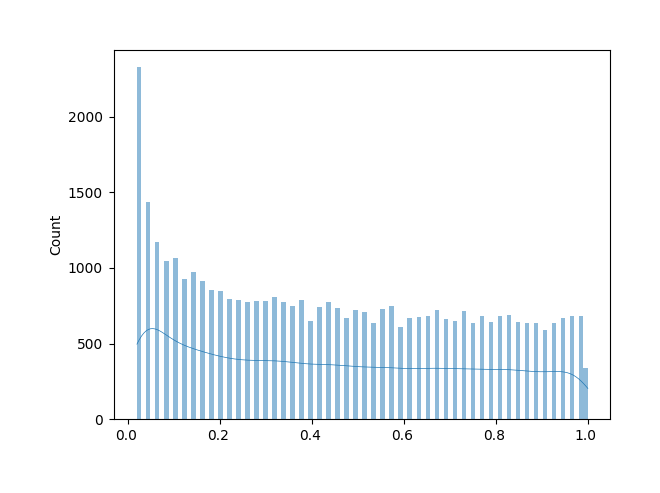

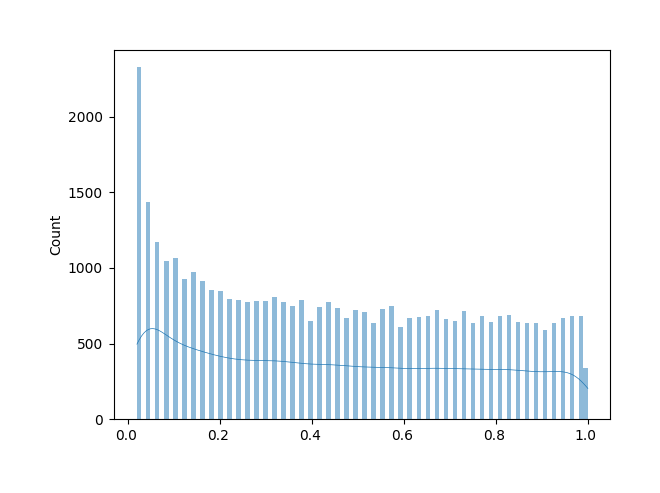

In [105]:
corrected_null_distribution = np.array([mat for mat in null_diff_matrices.values()]).max(axis=0)
p_values = {}
corrected_p_values = {}
for class1, class2 in combinations(classes, 2):
    print(f"Calculating p-values for classes: {class2} - {class1}")
    diff_matrix = diff_matrices[class2, class1]
    null_diff_matrix = null_diff_matrices[class2, class1]
    
    # Calculate p-values
    p_values[class2, class1] = nonparametric_p_value(diff_matrix, null_diff_matrix, alternative='two-sided')
    corrected_p_values[class2, class1] = nonparametric_p_value(diff_matrix, corrected_null_distribution, alternative='two-sided')
    sns.histplot(p_values[class2, class1].flatten(), bins=100, kde=True)
plt.show()
for cor_ps in corrected_p_values.values():
    sns.histplot(cor_ps.flatten(), bins=100, kde=True)
plt.show()

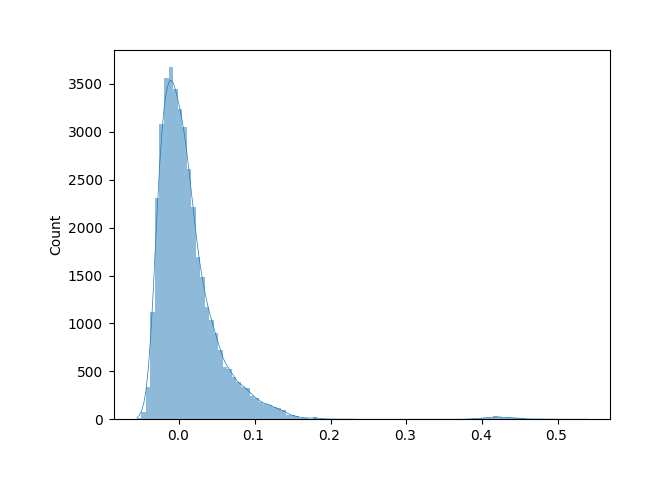

In [106]:
for combination in diff_matrices.keys():
    sns.histplot(ambient_diff_matrices[combination].flatten(), bins=100, kde=True)

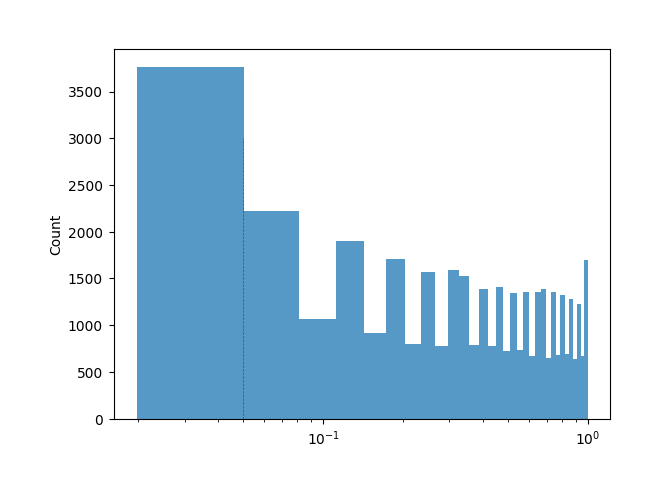

In [107]:
sns.histplot(p_values['decline', 'stable'].ravel())
plt.xscale('log')
plt.vlines(0.05, 0, 3000, color='red', linestyle='--')

In [108]:
from matplotlib.ticker import FixedLocator        

def set_network_ticks(axes, atlas):
    networks = np.array(atlas.macro_labels)
    sort_index = np.argsort(networks)
    n_regions = len(networks)
    ticks = []
    lbls = []
    prev_label = None
    for i, label in enumerate(networks[sort_index]):
        if label != prev_label:
            ticks.append(i)
            lbls.append(label)
            prev_label = label
            axes.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
            axes.vlines(i, 0, n_regions, colors="black", linestyles="dotted")

    ticks.append(i + 1)

    axes.yaxis.set_minor_locator(FixedLocator(ticks))
    axes.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
    axes.xaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
    axes.set_yticklabels(lbls, rotation=0, fontsize=12)
    axes.set_xticklabels(lbls, rotation=30, fontsize=12)

In [109]:
-np.log(0.05)

np.float64(2.995732273553991)

In [110]:
np.fill_diagonal(p_values[('decline', 'stable')], 1)

<Axes: >

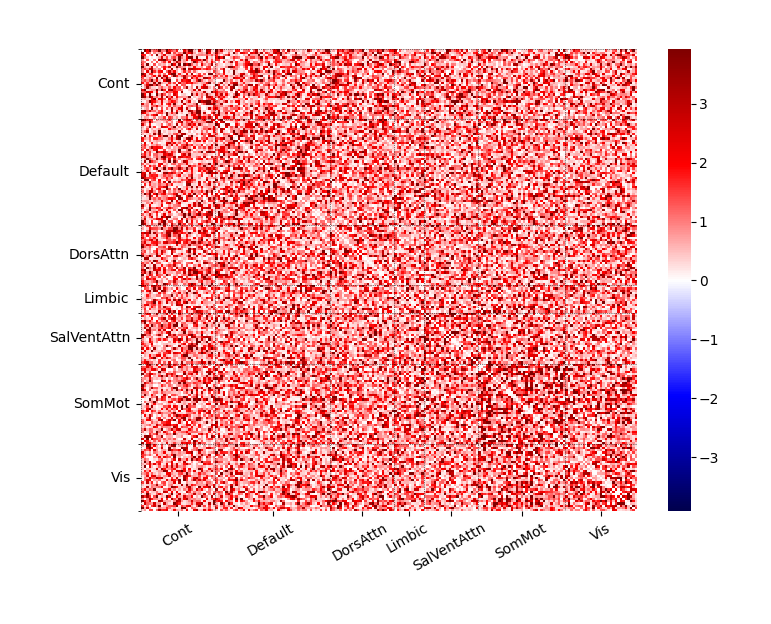

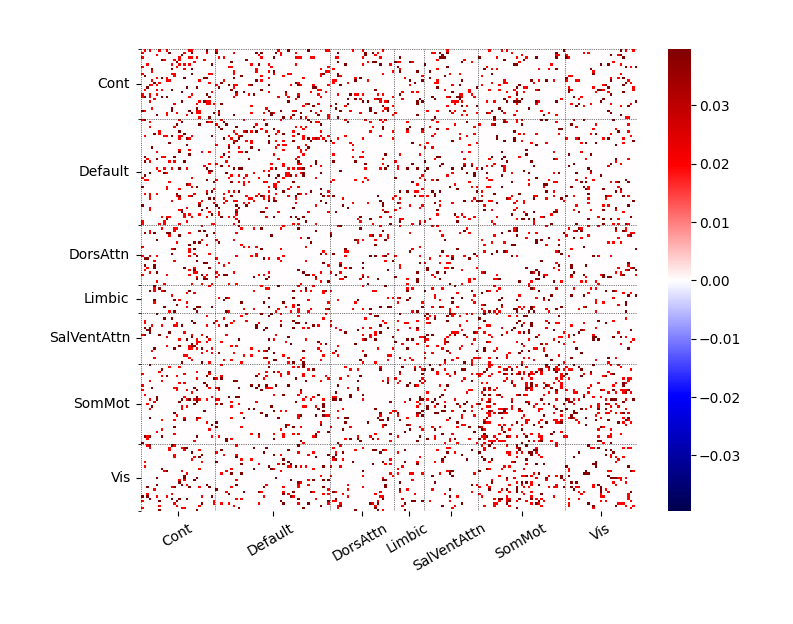

In [111]:
plot_matrix(-np.log(p_values[('decline',
  'stable')]), atlas,
  )
plot_matrix(np.where(p_values[('decline',
  'stable')] < 0.05, p_values[('decline',
  'stable')], 0), atlas)

[get_dataset_dir] Dataset found in C:\Users\achil\nilearn_data\schaefer_2018

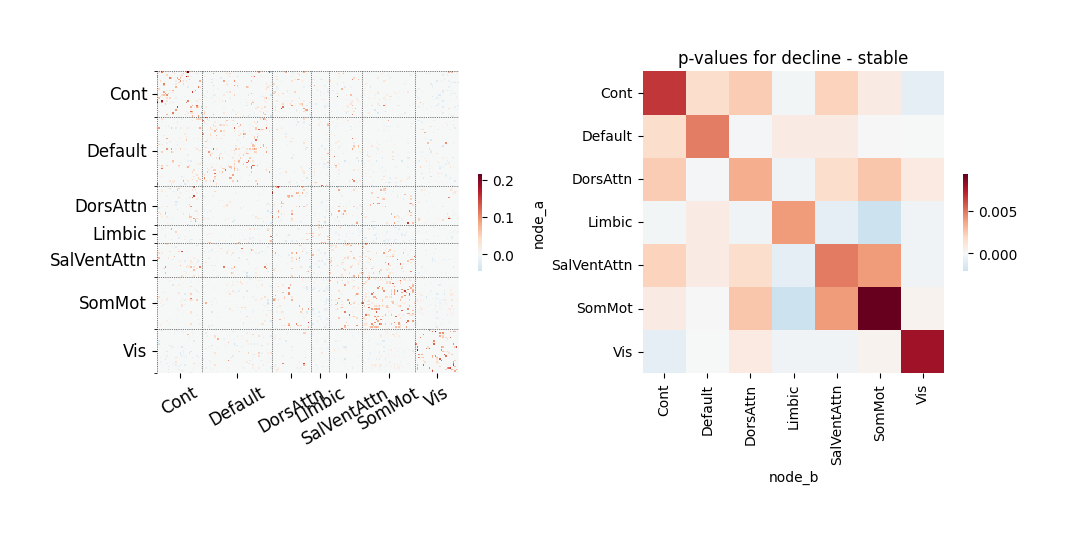

In [53]:
from neuroginius.matrices import MatrixResult
atlas = Atlas.from_name("schaefer200")

for class1, class2 in combinations(classes, 2):

    tmp_thresholded_mat = p_values[class2, class1]
    # tmp_thresholded_mat = corrected_p_values[class2, class1]
    tmp_ambient_mat = ambient_diff_matrices[class2, class1]
    # tmp_thresholded_mat = np.where(tmp_thresholded_mat < 0.05, tmp_thresholded_mat, 0)
    tmp_thresholded_mat = np.where(tmp_thresholded_mat < 0.05, tmp_ambient_mat, 0)
    # tmp_thresholded_mat = -np.log(tmp_thresholded_mat)
    # plot_matrix(tmp_thresholded_mat, atlas, cmap='RdBu_r', vmin=0, vmax=1)
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 10))
    sns.heatmap(MatrixResult(tmp_thresholded_mat, atlas=atlas).sorted_matrix, square=True, 
                center=0,
                cmap='RdBu_r', ax=ax1, cbar_kws={'shrink': 0.1})
    set_network_ticks(ax1, atlas)
    sns.heatmap(MatrixResult(tmp_thresholded_mat, atlas=atlas).get_macro_matrix(), square=True, 
                center=0,
                cmap='RdBu_r', ax=ax2, cbar_kws={'shrink': 0.1})
    # set_network_ticks(ax1, atlas)
    plt.title(f"p-values for {class2} - {class1}")
    plt.tight_layout()



In [54]:
def multivariate_blocks(block):
    return (block,)

Calculating combined p-values for classes: decline - stable


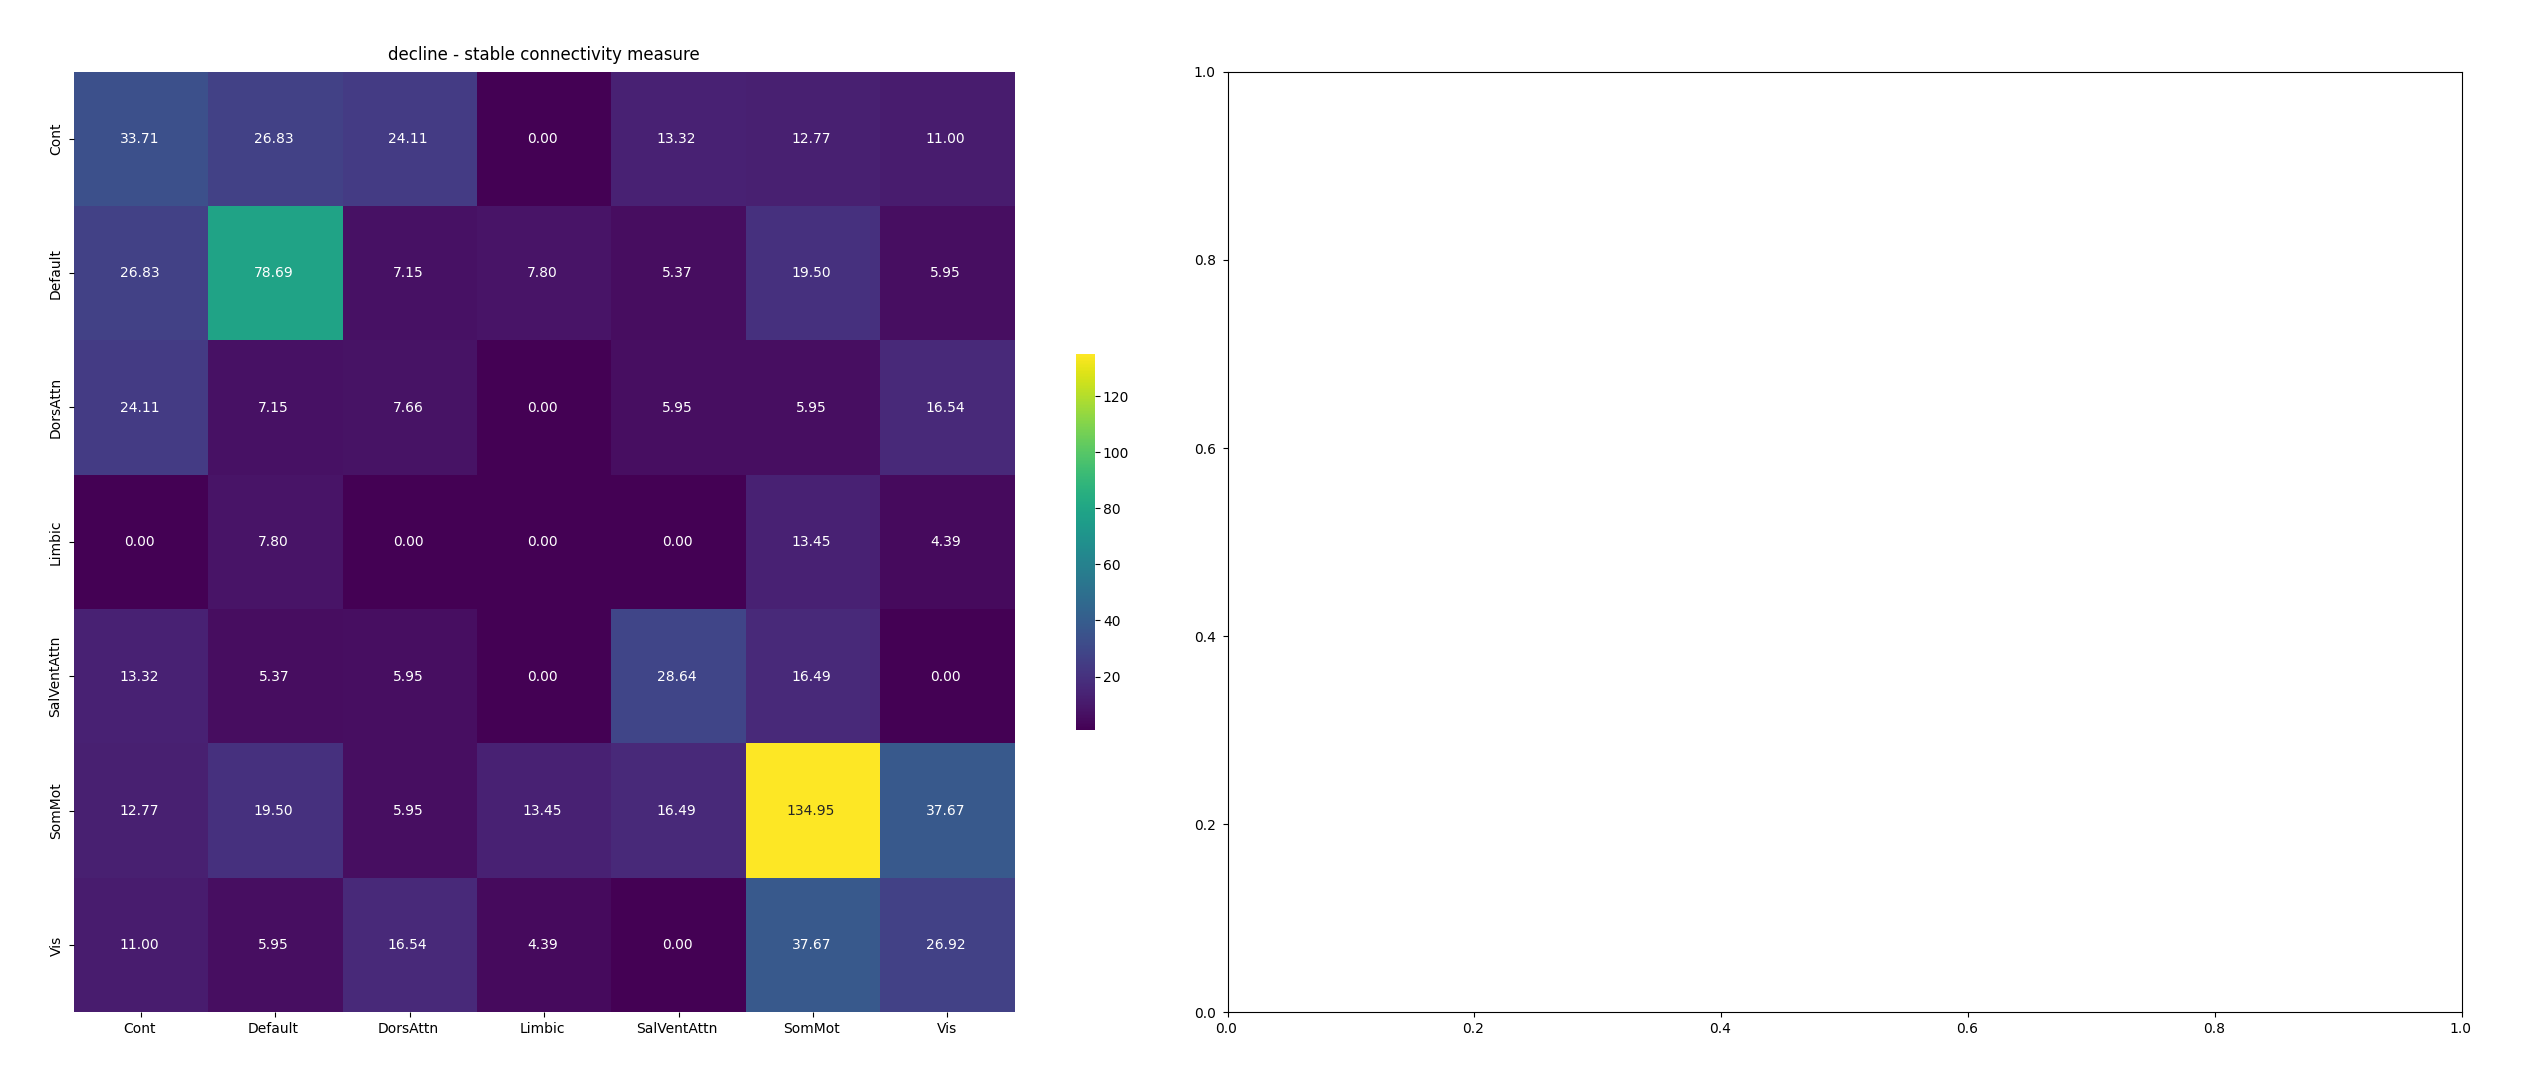

In [116]:
import numpy as np
from pycct import cct
from scipy.stats import combine_pvalues
from itertools import combinations_with_replacement
from statsmodels.stats.multitest import multipletests, fdrcorrection
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
axs = axs.flatten()
for i, (class1, class2) in enumerate(combinations(classes, 2)):
    print(f"Calculating combined p-values for classes: {class2} - {class1}")

    tmp_pvalues = p_values[class2, class1].copy()

    RSNs = np.unique(atlas.macro_labels)
    blocks = list(combinations_with_replacement(RSNs, 2))

    blocked_patterns = MatrixResult(tmp_pvalues, atlas).get_macro_matrix(agg_func=multivariate_blocks)

    results = pd.DataFrame(index=RSNs, columns=RSNs, dtype=float)
    tmp_results = []
    for block_a, block_b in blocks:

        # Example with equal weights
        pvalues = blocked_patterns.loc[block_a, block_b].copy().ravel()

        # result = cct(pvalues)
        result = combine_pvalues(pvalues, method='fisher').pvalue
        tmp_results.append(result)

    # correction for multiple comparisons
    result_cor = multipletests(tmp_results, method='fdr_bh')[1]
    # print(f"Combined p-value: {result}")
    for block_idx, (block_a, block_b) in enumerate(blocks):
        results.loc[block_a, block_b] = result_cor[block_idx]
        results.loc[block_b, block_a] = result_cor[block_idx]

    thresholded_results = results.copy()
    thresholded_results = -np.log(results)
    thresholded_results[thresholded_results < -np.log(0.05)] = 0
    sns.heatmap(thresholded_results, cmap='viridis', annot=True, fmt=".2f", square=True, vmin=0.95,
                ax=axs[i], cbar_kws={'shrink': 0.4})
    # plt.title(f"{class2} - {class1} connectivity measure")
    axs[i].set_title(f"{class2} - {class1} connectivity measure")

plt.tight_layout()
plt.show()

In [59]:
cat_diff_matrices = []
for key in diff_matrices.keys():
    tmp_diff_mat = diff_matrices[key]
    tmp_pvalues = corrected_p_values[key]
    tmp_diff_mat = np.where(tmp_pvalues < 0.05, tmp_diff_mat, 0)
    cat_diff_matrices.append(tmp_diff_mat[np.triu_indices(200, k=1)].ravel())
cat_diff_matrices = np.array(cat_diff_matrices).T

In [66]:
cat_ambient_haufe_matrices = np.array([mat[np.triu_indices(200, k=1)].ravel() for mat in haufe_matrices])

In [67]:
from scipy.spatial.distance import pdist

In [68]:
similarities = pd.DataFrame(squareform(1 - pdist(cat_ambient_haufe_matrices, metric='cosine')), index=classes, columns=classes)

sns.heatmap(similarities, center=0, cmap='RdBu_r', annot=True, square=True, cbar_kws={'shrink': 0.4})

ValueError: Shape of passed values is (1, 1), indices imply (2, 2)

<Axes: xlabel='node_b', ylabel='node_a'>

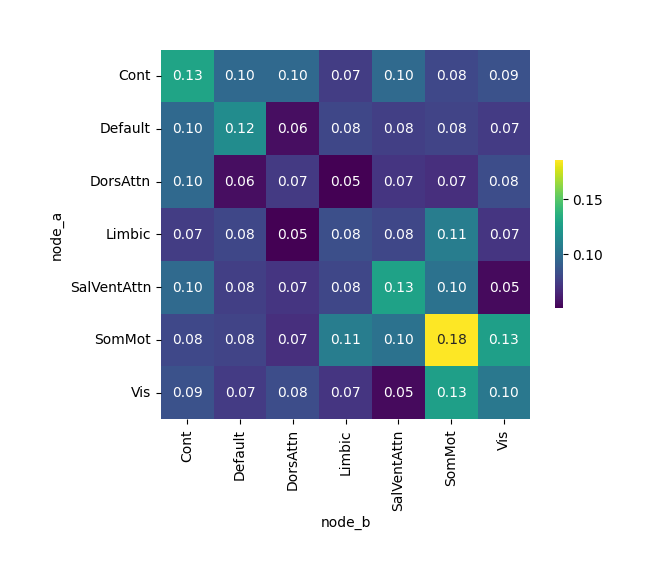

In [70]:
def count_significant(block):
    threshold = 0.05
    return (np.count_nonzero(block < 0.05) / block.size,)

pippo = MatrixResult(p_values['decline', 'stable'], atlas=atlas).get_macro_matrix(agg_func=count_significant)
sns.heatmap(pippo, cmap='viridis', annot=True, fmt=".2f", square=True, cbar_kws={'shrink': 0.4})


(19900,)


[NiftiLabelsMasker.inverse_transform] computing image from signals

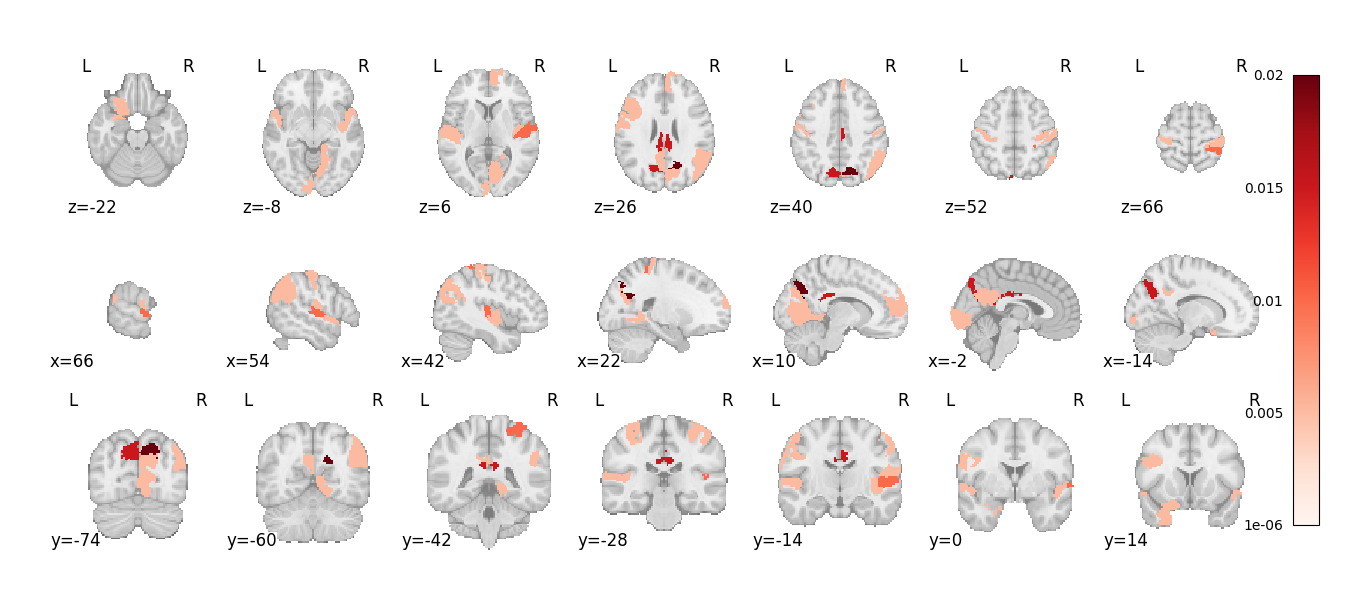

In [71]:
from nilearn.image import concat_imgs

classes_combinations = list(combinations(classes, 2))
percentile_masks = []
for tmp_mat in cat_diff_matrices.T:
    print(tmp_mat.shape)
    neg_mat = np.where(tmp_mat < 0, tmp_mat, 0)
    threshold = np.percentile(np.abs(tmp_mat), 99.9)
    mask = np.where(np.abs(tmp_mat) > threshold, 1, 0)
    percentile_masks.append(mask)
percentile_masks = np.array(percentile_masks).T


maps = []
for i in range(percentile_masks.shape[1]):
    tmp_combination = classes_combinations[i]
    class1, class2 = tmp_combination
    tmp_pippo = squareform(percentile_masks[:,i]).mean(axis=0)

    tmp_projected_pippo = masker.inverse_transform(tmp_pippo)

    from nilearn.plotting import plot_stat_map
    plot_stat_map(tmp_projected_pippo, display_mode='mosaic', cmap='Reds')
    tmp_projected_pippo.to_filename(f"tmp_mask_{class2}_{class1}.nii.gz")
    maps.append(tmp_projected_pippo)
concat_imgs(maps).to_filename(f"tmp_masks.nii.gz")

In [74]:
contrast = ('decline', 'stable')

tmp_diff_mat = diff_matrices[contrast]
tmp_null_diff_mats = null_diff_matrices[contrast]

In [ ]:
def extract_anatomical_label(label):
    region_tags = str(label).split("_")
    if len(region_tags) == 4:
        return region_tags[2]
    return region_tags[3]


anatomical_labels = tuple(map(extract_anatomical_label, atlas.labels))
# anatomical_labels

('Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'FEF',
 'FEF',
 'PrCv',
 'ParOper',
 'ParOper',
 'ParOper',
 'FrOperIns',
 'FrOperIns',
 'FrOperIns',
 'FrOperIns',
 'PFCl',
 'Med',
 'Med',
 'Med',
 'OFC',
 'OFC',
 'TempPole',
 'TempPole',
 'TempPole',
 'TempPole',
 'Par',
 'Par',
 'Par',
 'Temp',
 'OFC',
 'PFCl',
 'PFCl',
 'PFCl',
 'PFCl',
 'PFCl',
 'pCun',
 'Cing',
 'Cing',
 'Temp',
 'Temp',
 'Temp',
 'Temp',
 'Temp',
 'Par',
 'Par',
 'Par',
 'Par',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'pCunPCC',
 'pCunPCC',
 'pCunPCC',
 'pCunPCC',
 'PHC',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis'

In [76]:
unique_labels = np.unique(anatomical_labels)
mapping = {unique_labels[i]: i for i in range(len(unique_labels))}
anatomical_labels_int = pd.Series(anatomical_labels).map(mapping).values

[NiftiLabelsMasker.inverse_transform] computing image from signals

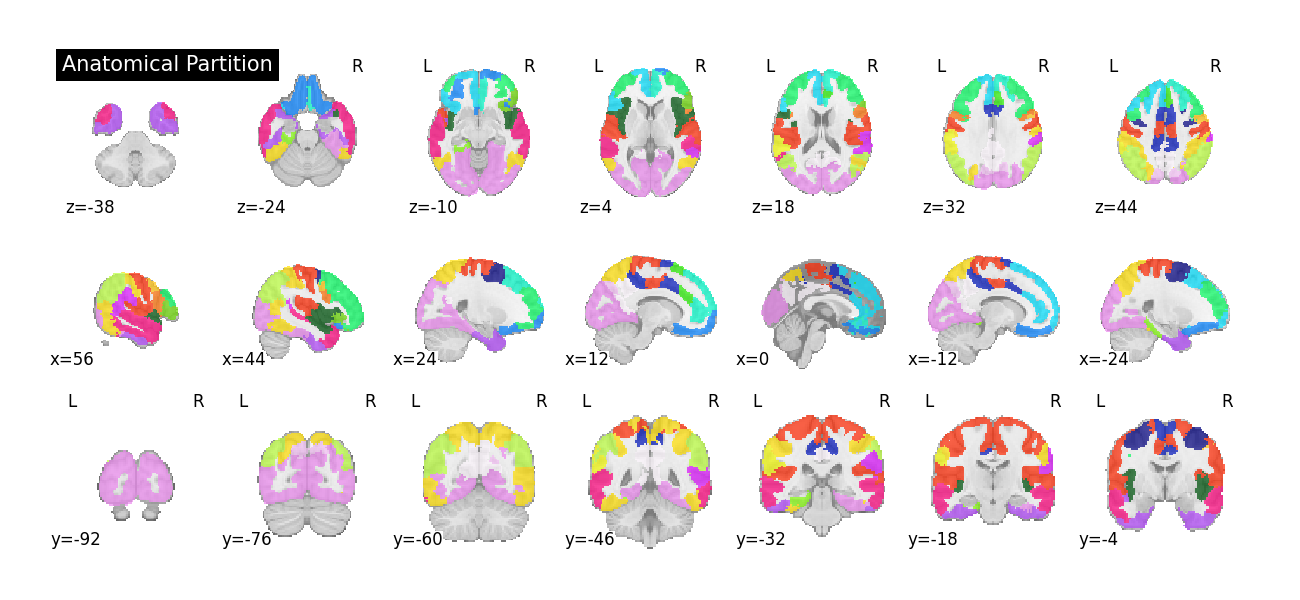

In [77]:
anatomical_atlas_map = masker.inverse_transform(anatomical_labels_int.astype(np.int32))

from nilearn.plotting import plot_roi
plot_roi(anatomical_atlas_map, title="Anatomical Partition", display_mode='mosaic')

In [78]:
class NiftiImageAtlas:
    def __init__(self, nifti_image, macro_labels=None):
        self.nifti_image = nifti_image
        self.labels = np.unique(nifti_image.get_fdata())
        if macro_labels is not None:
            self.macro_labels = macro_labels
        else:
            self.macro_labels = np.unique(self.labels)
        self.maps = nifti_image

    @classmethod
    def from_path(cls, path):
        from nilearn.image import load_img
        return cls(load_img(path))
    
anatomical_atlas = NiftiImageAtlas(anatomical_atlas_map, macro_labels=anatomical_labels)

In [79]:
anatomical_atlas

In [80]:
def to_matrix(vec):
    n = int(np.sqrt(len(vec) * 2))
    mat = np.zeros((n, n))
    mat[np.triu_indices(n, k=0)] = vec
    mat += mat.T
    np.fill_diagonal(mat, np.diag(mat) / 2)
    return mat

def binarize(matrix):
    pos_matrix = np.zeros_like(matrix)
    neg_matrix = np.zeros_like(matrix)

    pos_matrix[matrix > 0] = 1
    neg_matrix[matrix < 0] = 1
    return pos_matrix, neg_matrix

def degree_centrality(matrix):
    pos_matrix, neg_matrix = binarize(matrix)
    pos_degree = pos_matrix.sum(axis=0)
    neg_degree = neg_matrix.sum(axis=0)
    return pos_degree, neg_degree

def matrix_to_chord(matrix, atlas, percentile=99.8,
                    diverging=False, 
                    positive_only=True,
                    RSN_to_color=None, title=None,
                    filename=None):
    from nichord.convert import convert_matrix
    from nichord.chord import plot_chord, plot_arcs
    from nichord.coord_labeler import get_idx_to_label


    RSNs = np.unique(atlas.macro_labels)
    idx_to_label = {i: RSN for i, RSN in enumerate(np.unique(atlas.macro_labels))}

    # tmp_coefs = MatrixResult(squareform(cluster_coefs[9]), atlas).get_macro_matrix().values
    tmp_coefs = matrix.copy()
    if percentile is not None:
        perc_thr = np.percentile(tmp_coefs, percentile)
    else:
        perc_thr = -np.inf
    
    vmin, vmax = None, None
    if diverging:
        cmap = 'RdBu_r'
        vmin = np.min(tmp_coefs)
        vmax = np.max(tmp_coefs) 
        vmax = np.max((np.abs(vmin), np.abs(vmax)))
        vmin = -vmax
        # tmp_coefs[np.abs(tmp_coefs) < perc_thr] = 0
    else:
        if positive_only:
            vmin = 0
            cmap = 'Reds'
            tmp_coefs[tmp_coefs < perc_thr] = 0
        else:
            vmax = 0
            vmin = None
            cmap = 'Blues'
            tmp_coefs[tmp_coefs > -perc_thr] = 0

    
    edges, edge_weights = convert_matrix(tmp_coefs)

    # fp_chord = 'tmp.png'
    fp_chord = filename
    max_linewidth = 8
    scaling_factor = max_linewidth / edge_weights.max()
    plot_chord(idx_to_label, edges, edge_weights=edge_weights, fp_chord=fp_chord, 
            network_colors=RSN_to_color,
            linewidths=(edge_weights * scaling_factor).tolist(), alphas=0.9, do_ROI_circles=True, label_fontsize=24, 
            # July 2023 update allows changing label fontsize
            do_ROI_circles_specific=False, ROI_circle_radius=0.01,
            # cmap='RdBu_r',
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            do_monkeypatch=True,
            black_BG=True,
            plot_count=False,
            arc_setting=False,
            dpi=600,
            # edge_threshold=5
            )
    if title is not None:
        plt.title(f'{title}', fontsize=10)
    # plt.show()

Calculating combined p-values for classes: decline - stable


[NiftiLabelsMasker.inverse_transform] computing image from signals

[NiftiLabelsMasker.inverse_transform] computing image from signals

[NiftiLabelsMasker.inverse_transform] computing image from signals

C:\Users\achil\AppData\Local\Temp\ipykernel_16596\2353801488.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


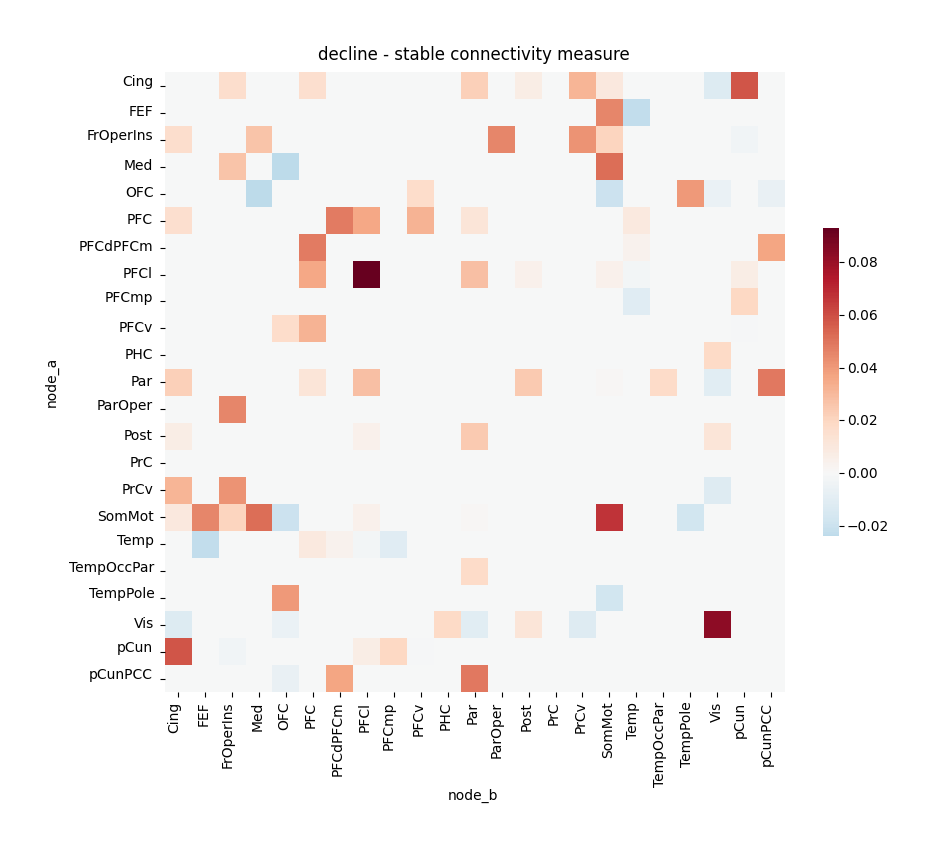

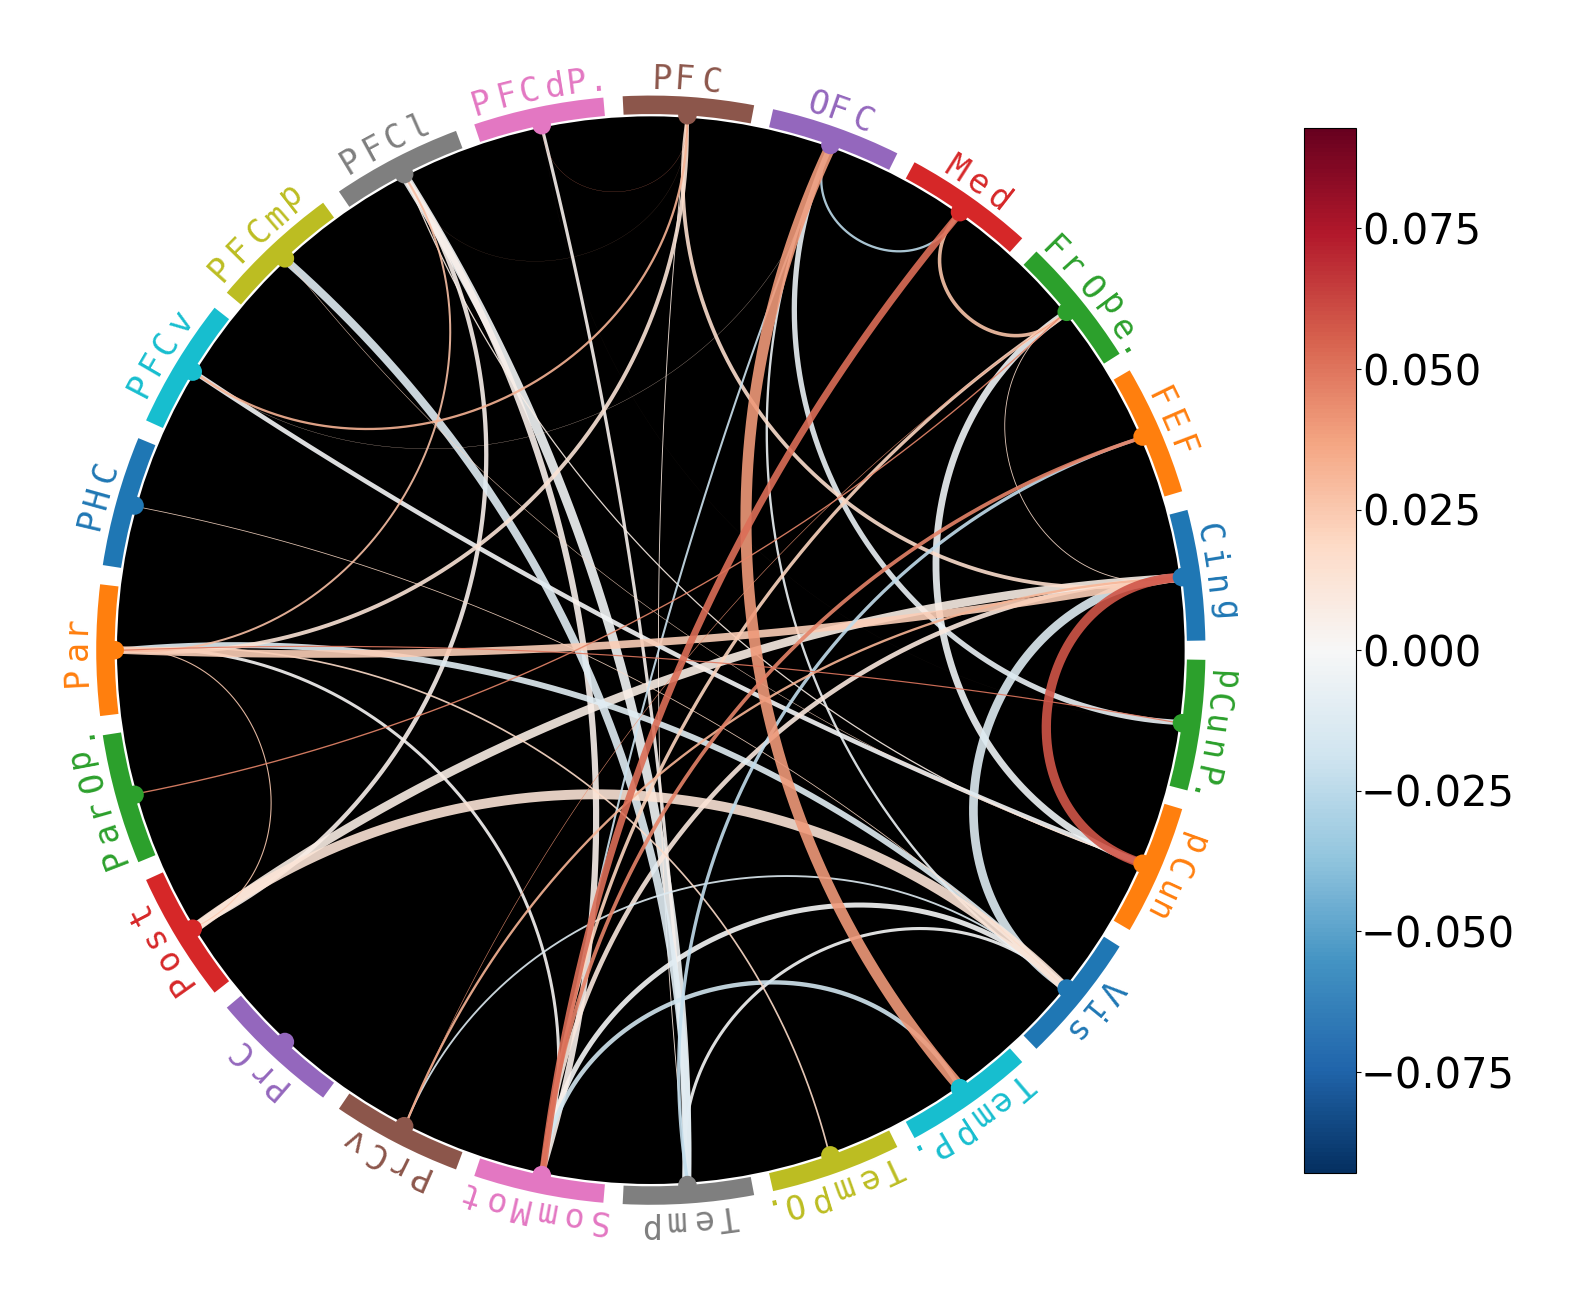

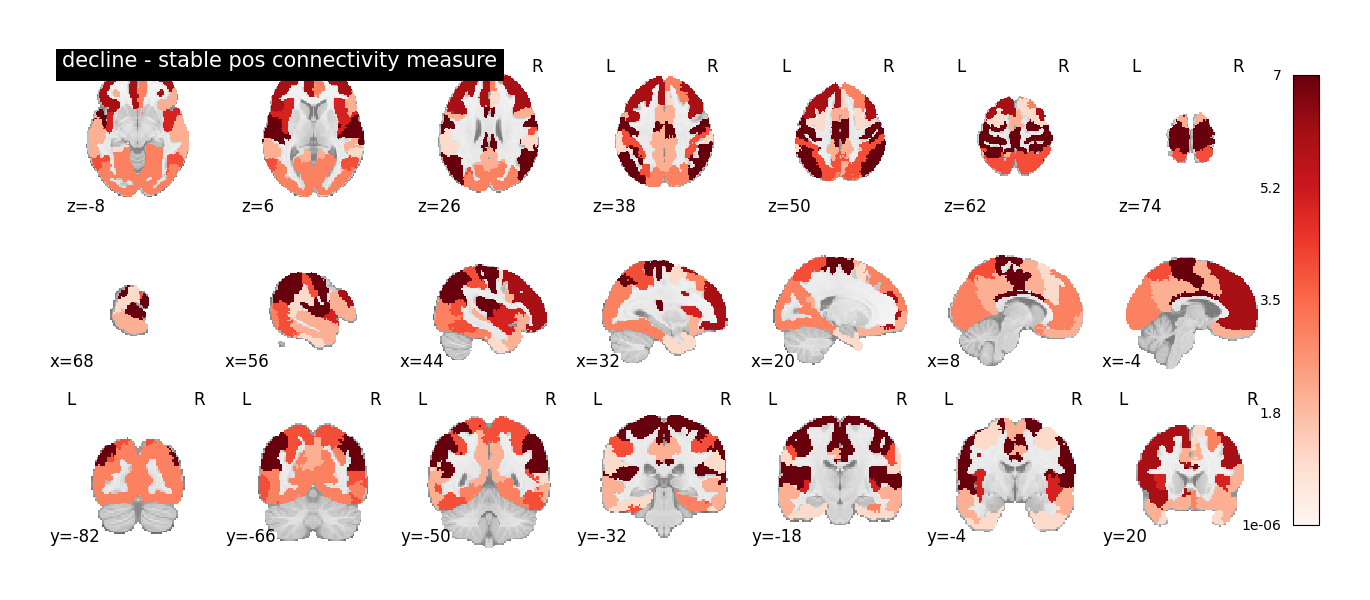

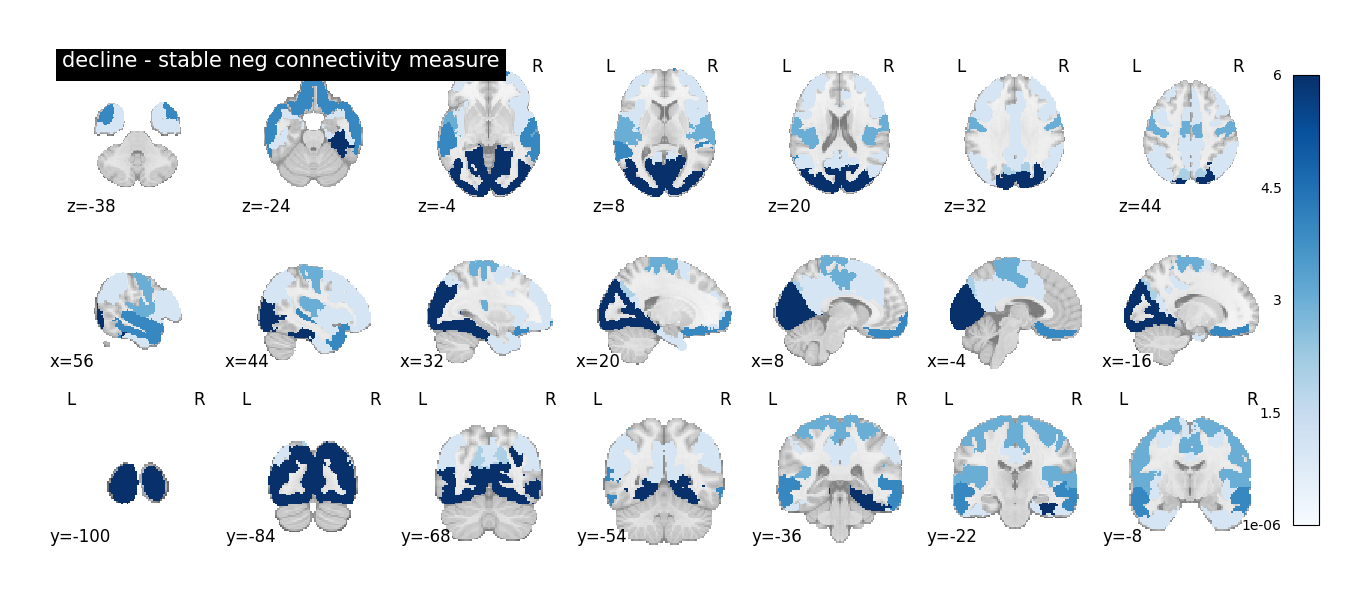

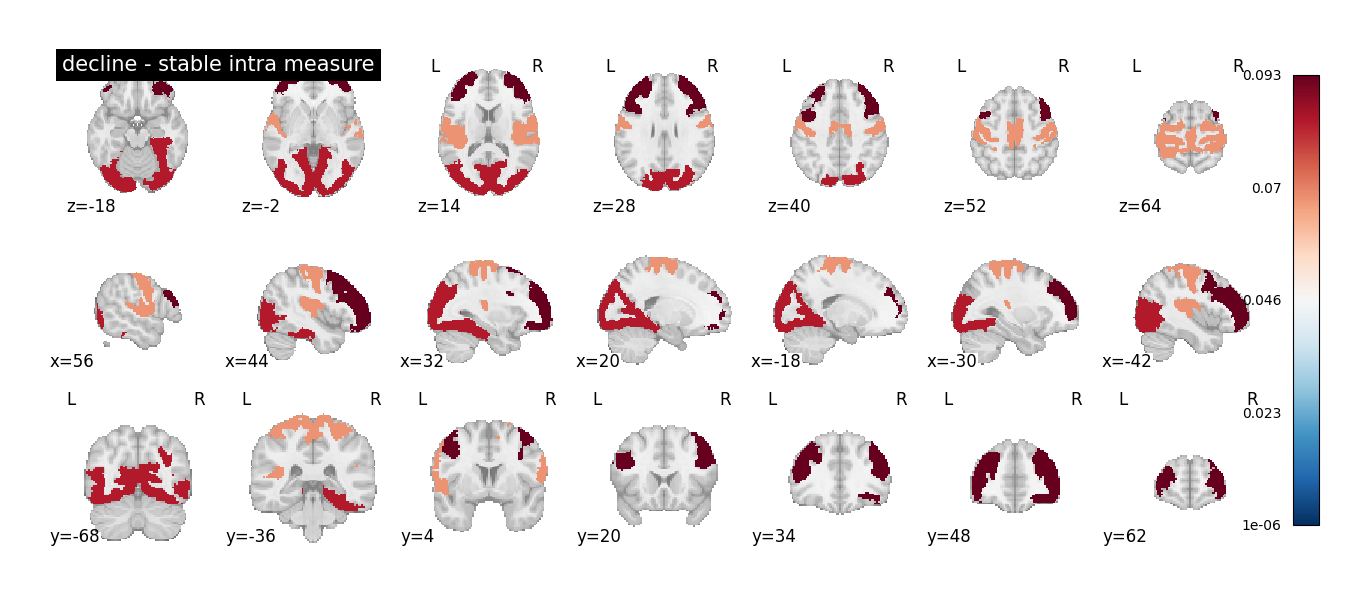

In [87]:
import numpy as np
from pycct import cct
from scipy.stats import combine_pvalues
from itertools import combinations_with_replacement
from statsmodels.stats.multitest import multipletests, fdrcorrection
from nilearn.connectome import vec_to_sym_matrix

anatomical_networks = np.unique(anatomical_labels)
blocks = list(combinations_with_replacement(anatomical_networks, 2))

final_blocklevel_results = {}

stacked_ambient_mats_thresholded = []
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
axs = [ax]

for i, (class1, class2) in enumerate(combinations(classes, 2)):
    print(f"Calculating combined p-values for classes: {class2} - {class1}")

    tmp_pvalues = p_values[class2, class1].copy()
    blocked_patterns = MatrixResult(tmp_pvalues, anatomical_atlas).get_macro_matrix(agg_func=multivariate_blocks)
    tmp_ambient_mat = ambient_diff_matrices[class2, class1]
    blocked_ambient_matrices = MatrixResult(tmp_ambient_mat, anatomical_atlas).get_macro_matrix(agg_func=multivariate_blocks)

    results = pd.DataFrame(index=anatomical_networks, columns=anatomical_networks, dtype=float)
    tmp_results = []
    tmp_stats = []
    for block_a, block_b in blocks:

        pvalues = blocked_patterns.loc[block_a, block_b].copy().ravel()
        differences = blocked_ambient_matrices.loc[block_a, block_b].copy().ravel()

        # result = cct(pvalues)
        # result = combine_pvalues(pvalues, method='fisher')
        weights = differences.copy()
        weights[weights < 0] = -1
        weights[weights > 0] = 1
        result = combine_pvalues(pvalues, method='fisher', weights=weights)
        pvalue = result.pvalue
        tmp_results.append(pvalue)
        stat = result.statistic
        # Use Lancaster's method to obtainsignedzscore
        # _, stat = lancaster(pvalues, weights)
        tmp_stats.append(stat)

    # correction for multiple comparisons
    result_cor = multipletests(tmp_results, method='fdr_bh')[1]

    for block_idx, (block_a, block_b) in enumerate(blocks):
        results.loc[block_a, block_b] = result_cor[block_idx]
        results.loc[block_b, block_a] = result_cor[block_idx]
    
    significance_mask = np.where(results.values < 0.05, True, False)
    
    tmp_ambient_mat_thresholded = np.where(tmp_pvalues, tmp_ambient_mat, 0)
    stacked_ambient_mats_thresholded.append(tmp_ambient_mat_thresholded[np.triu_indices(200, k=1)].ravel())
    block_thresholded_differences = MatrixResult(tmp_ambient_mat_thresholded, atlas=anatomical_atlas).get_macro_matrix(lambda block: (block.mean(),))
    block_thresholded_differences = block_thresholded_differences.where(significance_mask, 0)
    final_blocklevel_results[class2, class1] = block_thresholded_differences

    matrix_to_chord(block_thresholded_differences.values, anatomical_atlas, percentile=None,
                diverging=True,
                positive_only=False,)

    pos_centrality, neg_centrality = degree_centrality(block_thresholded_differences)
    pos_results_vec = np.zeros(len(anatomical_labels))
    neg_results_vec = np.zeros(len(anatomical_labels))
    for idx, label in enumerate(anatomical_labels_int):
        pos_results_vec[idx] = pos_centrality[label]
        neg_results_vec[idx] = neg_centrality[label]

    intra_results_vec = np.zeros(len(anatomical_labels))
    for idx, label in enumerate(anatomical_labels):
        intra_results_vec[idx] = block_thresholded_differences.loc[label, label]

    # result_to_plot = pd.DataFrame(to_matrix(tmp_stats), 
    #                               index=anatomical_networks, 
    #                               columns=anatomical_networks)
    # result_to_plot = result_to_plot.where(significance_mask, 0)
    result_to_plot = block_thresholded_differences
    sns.heatmap(result_to_plot, center=0, cmap='RdBu_r', ax=axs[i],
                square=True,
                cbar_kws={'shrink': 0.4}, annot=False)

    axs[i].set_title(f"{class2} - {class1} connectivity measure")

    pos_projected_results = masker.inverse_transform(pos_results_vec)
    neg_projected_results = masker.inverse_transform(neg_results_vec)
    intra_projected_results = masker.inverse_transform(intra_results_vec)

    plot_stat_map(pos_projected_results, display_mode='mosaic', cmap='Reds', 
                  title=f"{class2} - {class1} pos connectivity measure", symmetric_cbar=False)
    plot_stat_map(neg_projected_results, display_mode='mosaic', cmap='Blues', 
                  title=f"{class2} - {class1} neg connectivity measure", symmetric_cbar=False)
    plot_stat_map(intra_projected_results, display_mode='mosaic', cmap='RdBu_r', 
                  title=f"{class2} - {class1} intra measure", symmetric_cbar=False)
    intra_projected_results.to_filename(f"tmp_intra_projection_{class2}_{class1}.nii.gz")

plt.tight_layout()
plt.show()

In [88]:
from scipy.stats import norm
def lancaster(pvalues, weights):
    """
    Combine p-values using the Lancaster method.

    Parameters:
    - pvalues: array-like, list of p-values to combine.
    - weights: array-like, list of weights corresponding to each p-value.

    Returns:
    - combined_pvalue: float, the combined p-value.
    """
    if len(pvalues) != len(weights):
        raise ValueError("Length of pvalues and weights must be the same.")

    # Convert weights to a NumPy array
    weights = np.array(weights)

    # Convert p-values to Z-scores
    z_scores = norm.ppf(1 - np.array(pvalues))

    # Weighted Z-scores
    weighted_z = np.sum(weights * z_scores) / np.sqrt(np.sum(weights**2))

    # Convert back to p-value
    combined_pvalue = 1 - norm.cdf(weighted_z)

    return combined_pvalue, weighted_z

In [89]:
np.count_nonzero(np.diag(mat))

NameError: name 'mat' is not defined

In [ ]:
final_blocklevel_results['steep', 'stable']

classes_combinations_str = [f"{class2}_{class1}" for class1, class2 in combinations(classes, 2)]

intra_inter_counts = pd.DataFrame(index=classes_combinations_str, columns=['intra', 'inter'], dtype=float)
for (class1, class2), mat in final_blocklevel_results.items():
    n_positive_intra = np.count_nonzero(np.diag(mat) > 0)
    n_negative_intra = np.count_nonzero(np.diag(mat) < 0)
    intra_count = (n_positive_intra + n_negative_intra) / np.diag(mat).size
    n_positive_inter = np.count_nonzero(mat > 0) - n_positive_intra
    n_negative_inter = np.count_nonzero(mat < 0) - n_negative_intra
    inter_count = (n_positive_inter + n_negative_inter) / len(np.triu_indices(mat.shape[0], k=1)[0])
    intra_inter_counts.loc[f"{class1}_{class2}", 'intra'] = intra_count
    intra_inter_counts.loc[f"{class1}_{class2}", 'inter'] = inter_count

In [ ]:
intra_inter_counts

,intra,inter
slow_stable,1.0,0.703557
steep_stable,1.0,0.988142
steep_slow,1.0,0.007905


In [ ]:
intra_inter_counts = pd.melt(intra_inter_counts.reset_index(), id_vars='index', var_name='type', value_name='value')

<Axes: xlabel='index', ylabel='value'>

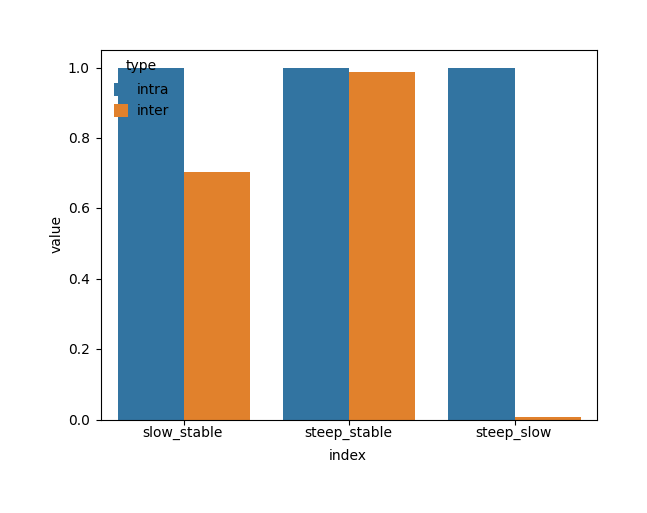

In [ ]:
sns.barplot(data=intra_inter_counts, x='index', y='value', hue='type')

In [ ]:
stacked_final_blocklevel_results = []
for key in final_blocklevel_results.keys():
    stacked_final_blocklevel_results.append(final_blocklevel_results[key].values[np.triu_indices(23, k=1)].ravel())
stacked_final_blocklevel_results = pd.DataFrame(stacked_final_blocklevel_results,
                                                index=classes_combinations_str)

In [ ]:
np.corrcoef(stacked_final_blocklevel_results)

array([[ 1.        ,  0.78542231, -0.17161139],
       [ 0.78542231,  1.        , -0.1259797 ],
       [-0.17161139, -0.1259797 ,  1.        ]])